# Importing and Installing Libraries

In [39]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install arch
from arch import arch_model

!pip install pykalman

from pykalman import KalmanFilter
import warnings
warnings.filterwarnings("ignore")


# Processing Data and Creating Basic Features

This Python script provides a function to process high-frequency order book data. It automates the workflow from a raw CSV file to a feature-rich DataFrame ready for modeling.
* Timestamp Correction : It loads the raw data and corrects timestamps, handling cases with multiple entries per minute by creating a sequential, second-level index.

1. Gap-Filling: The data is resampled to a 1-second frequency, and any missing data points are filled using a forward-fill (ffill) method to create a continuous time series.

2. Feature Engineering: It then calculates a set of fundamental features from the order book, including log returns, rolling volatility, Weighted Average Price (WAP), and Order Book Imbalance (OBI).

> *process_asset_data* function creates dataframes like ETH_train_filled, ETH_test_filled, BTC_train_filled etc.

In [3]:
def calculate_wap_robust(df, level=1):
    bid_p, ask_p = f'bid_price{level}', f'ask_price{level}'
    bid_v, ask_v = f'bid_volume{level}', f'ask_volume{level}'
    numerator = (df[bid_p] * df[ask_v]) + (df[ask_p] * df[bid_v])
    denominator = df[bid_v] + df[ask_v]
    return np.where(denominator > 0, numerator / denominator, df['mid_price'])

def process_asset_data(asset_name, directory = 'train'):
    """creates dataframes with index as proper timestamp and forward filled data 
    """
    
    print(f"\n--- Processing data for {asset_name} ---")
    
    file_path = f"/kaggle/input/gq-dataset/{directory}/{asset_name}.csv"
    df = pd.read_csv(file_path)

    try:
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d-%m-%Y %H:%M')
    except ValueError:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
    if df['timestamp'].dt.second.sum() == 0:
        df['seconds_to_add'] = df.groupby('timestamp').cumcount()
        df['new_timestamp'] = df['timestamp'] + pd.to_timedelta(df['seconds_to_add'], unit='s')
        df.drop(columns=['timestamp', 'seconds_to_add'], inplace=True)
        df.rename(columns={'new_timestamp': 'timestamp'}, inplace=True)

    df = df.set_index('timestamp').sort_index()

    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='S')
    df_filled = df.reindex(full_range).ffill().bfill()
    print(f"Loaded and resampled to {len(df_filled)} rows.")
    
    df_filled['log_return'] = np.log(df_filled['mid_price']).diff()
    df_filled[f'rolling_vol_{asset_name}'] = df_filled['log_return'].rolling(window=600).std()
    
    for i in range(1, 6):
        df_filled[f'wap{i}_{asset_name}'] = calculate_wap_robust(df_filled, level=i)
        
    bid_vols = df_filled[[f'bid_volume{i}' for i in range(1, 6)]].sum(axis=1)
    ask_vols = df_filled[[f'ask_volume{i}' for i in range(1, 6)]].sum(axis=1)
    df_filled[f'obi_{asset_name}'] = bid_vols / (bid_vols + ask_vols)
    
    df_filled.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_filled.ffill(inplace=True)
    df_filled.bfill(inplace=True)
    print("Basic feature engineering complete.")

    
    return {f"{asset_name}_{directory}_filled": df_filled}

# Feature Creation


## Volatility Features

Our main focus would be trying to predict volatility under different assumptions. One such attempt is rolling historical volatility, but it is based on only historical data and not robust. So we use the following features as substitutes of Implied Volatility:
> create_advanced_volatility_features
* OHLC Resampling: The function first transforms the 1-second mid_price data into lower-frequency OHLC bars (e.g., over 15-minute intervals).
* Estimator Calculation: It then uses these bars to calculate three distinct volatility measures:
  1. **Parkinson Volatility**: Uses the high-low price range. The variance is calculated as: $$\sigma^2 = \frac{1}{4 ln 2} (ln(\frac{High}{Low}))^2.$$
  2. **Garman-Klass Volatility**: Extends the Parkinson model by also incorporating the open and close prices. The variance is calculated as: $$\sigma^2=0.5 (ln(\frac{High}{Low}))^2 - (2ln2-1)(ln(\frac{Close}{Open}))^2 $$
  3. **Yang-Zhang Volatility**: A highly robust estimator that combines the intraday price range with the overnight price jump. The variance is calculated as: $$\sigma_{t}^2 =  k (\ln(\frac{Open_{t}}{Close_{t-1}}))^2+ (1-k) \sigma^2_{Garman-Klass}$$ where $k= \frac{0.34}{1.34+\frac{n+1}{n-1}}$, $n$ is the number of seconds/mins to look behind (15 here).


> add_advanced_vol_features

This function generates volatility forecasts using two distinct time-series models. To ensure the features are valid for predictive modeling and free from data leakage, it follows a strict "fit on train, predict on test" methodology. 
1. **GARCH Model**: It fits a GARCH(1,1) model on the training set's price returns to capture volatility clustering. The formula for the conditional variance is $$\sigma_{t}^2 = \omega + \alpha \epsilon_{t-1}^2+\beta \sigma_{t-1}^2$$
2.  **Kalman Filter**: It uses a Kalman filter to estimate the hidden volatility state from the observed squared returns. The filter is trained on the training set, and its final state is used to initialize an online, one-step-at-a-time forecast for the test set.


>add_bollinger_bandwidth

This function calculates the Bollinger Bandwidth, a classic technical indicator that measures volatility relative to the current price level. It calculates a central moving average and upper/lower bands set at a specified number of standard deviations away, then computes the normalized width between the bands. This is particularly useful for identifying periods of volatility contraction (a "squeeze").
$$Bandwidth = \frac{UpperBand - LowerBand}{Middle Band}$$

In [4]:
def add_advanced_vol_features(train_df, test_df, asset_name):
    """
    Fits GARCH and Kalman models on the training data and generates features
    for both the training and testing sets.
    """
    print(f"Adding GARCH & Kalman features for {asset_name}...")
    
    # --- GARCH Feature ---
    # Fit on training data
    train_returns = 100 * np.log(train_df['mid_price']).diff().dropna()
    garch_model = arch_model(train_returns, p=1, q=1, vol='Garch')
    garch_fit = garch_model.fit(disp='off')
    
    # Add in-sample feature to the training set
    train_df[f'garch_vol_{asset_name}'] = np.sqrt(garch_fit.conditional_volatility) / 100
    
    # Generate out-of-sample forecast for the test set
    forecasts = garch_fit.forecast(horizon=len(test_df), reindex=False)
    predicted_variance = forecasts.variance.iloc[0].values
    aligned_forecasts = pd.Series(predicted_variance, index=test_df.index)
    test_df[f'garch_vol_{asset_name}'] = np.sqrt(aligned_forecasts)

    # --- Kalman Filter Feature ---
    # Prepare observed variable (squared returns)
    train_obs = np.log(train_df['mid_price']).diff().dropna()**2
    test_obs = np.log(test_df['mid_price']).diff().dropna()**2
    
    # Initialize and fit on training data
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1, transition_covariance=0.01, 
                      observation_covariance=1, transition_matrices=[1], 
                      observation_matrices=[1], initial_state_covariance=1)
    state_means_train, state_covs_train = kf.filter(train_obs.values)
    
    #  Add in-sample feature to the training set
    train_df[f'kalman_vol_{asset_name}'] = pd.Series(np.sqrt(np.maximum(0, state_means_train.flatten())), index=train_obs.index)

    #  Generate out-of-sample forecast for the test set (online)
    last_state_mean = state_means_train[-1]
    last_state_cov = state_covs_train[-1]
    state_means_test = []
    for obs in test_obs.values:
        last_state_mean, last_state_cov = kf.filter_update(
            filtered_state_mean=last_state_mean,
            filtered_state_covariance=last_state_cov,
            observation=obs
        )
        state_means_test.append(last_state_mean[0])
    
    test_df[f'kalman_vol_{asset_name}'] = pd.Series(np.sqrt(np.maximum(0, state_means_test)), index=test_obs.index)

    
    
    # --- Final Cleanup ---
    train_df.ffill(inplace=True)
    train_df.bfill(inplace=True)
    test_df.ffill(inplace=True)
    test_df.bfill(inplace=True)
    
    print("GARCH & Kalman features added.")
    
    return train_df, test_df


def create_advanced_volatility_features(df, asset_name = 'eth', window_minutes=15):
    """
    Creates OHLC bars and calculates advanced volatility estimators.
    """
    print(f"Calculating advanced volatility for {asset_name}...")
    
    #  Create OHLC Bars 
    # Resample the 1-second mid_price data into N-minute bars
    resample_period = f'{window_minutes}min'
    ohlc = df['mid_price'].resample(resample_period).ohlc()
    
    # Calculate log returns for the estimators
    log_ho = np.log(ohlc['high'] / ohlc['open'])
    log_lo = np.log(ohlc['low'] / ohlc['open'])
    log_co = np.log(ohlc['close'] / ohlc['open'])
    log_oc = np.log(ohlc['open'] / ohlc['close'].shift(1)) # Overnight jump

    # Calculate Volatility Estimators 
    # Parkinson Volatility
    parkinson_vol = np.sqrt((1 / (4 * np.log(2))) * ((log_ho - log_lo) ** 2))
    
    # Garman-Klass Volatility
    garman_klass_vol = np.sqrt(0.5 * (log_ho - log_lo)**2 - (2*np.log(2) - 1) * log_co**2)
    
    # Yang-Zhang Volatility
    k = 0.34 / (1.34 + (window_minutes + 1) / (window_minutes - 1))
    yang_zhang_vol = np.sqrt(k*log_oc**2 + (1-k)*(0.5 * (log_ho - log_lo)**2 - (2*np.log(2) - 1) * log_co**2))

    #  Add Features to OHLC DataFrame 
    ohlc[f'parkinson_vol_{asset_name}'] = parkinson_vol
    ohlc[f'garman_klass_vol_{asset_name}'] = garman_klass_vol
    ohlc[f'yang_zhang_vol_{asset_name}'] = yang_zhang_vol
    
    # Merge Features Back into Original DataFrame 
    # Select only the new volatility features
    vol_features = ohlc[[f'parkinson_vol_{asset_name}', f'garman_klass_vol_{asset_name}', f'yang_zhang_vol_{asset_name}']]
    
    # Merge them back to the original high-frequency DataFrame
    merged_df = df.merge(vol_features, left_index=True, right_index=True, how='left')
    
    # Forward-fill the values, as the volatility is constant for each 15-minute block
    merged_df.ffill(inplace=True)
    merged_df.bfill(inplace=True)
    
    print("Advanced volatility features created.")
    return merged_df


def add_bollinger_bandwidth(df, window=600, k=2):
    """
    Calculates and adds Bollinger Bandwidth as a new feature.
    
    Args:
        df (pd.DataFrame): The input DataFrame with a 'mid_price' column.
        window (int): The moving average window size (e.g., 600 for 10 minutes).
        k (int): The number of standard deviations for the bands.
    """
    df['bb_middle'] = df['mid_price'].rolling(window=window).mean()
    df['bb_std'] = df['mid_price'].rolling(window=window).std()
    df['bb_upper'] = df['bb_middle'] + (df['bb_std'] * k)
    df['bb_lower'] = df['bb_middle'] - (df['bb_std'] * k)
    df['bollinger_bandwidth'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']
    df.drop(columns=['bb_middle', 'bb_std', 'bb_upper', 'bb_lower'], inplace=True)
    
    return df


## Spline Feature 

A **spline** is a smooth, piecewise polynomial function used to model non-linear relationships between a predictor and a target.  Here , we use **B-splines** (`bs()` in Patsy) on a `time_numeric` variable to capture complex time-dependent patterns but only for ETH data.

- **Why use splines?**  
  They allow flexibility without overfitting by breaking the predictor into sections and fitting low-degree polynomials.

- **Key parameters:**  
  - `df=30`: Number of spline basis functions (controls flexibility).  
  - `degree=3`: Cubic spline (smooth curves).  
  - `include_intercept=False`: Avoids redundant intercept terms.


In [17]:
import statsmodels.api as sm
from patsy import dmatrices, dmatrix

ETH_train_filled['time_numeric'] = (ETH_train_filled.index - ETH_train_filled.index.min()).total_seconds()
ETH_test_filled['time_numeric'] = (ETH_test_filled.index - ETH_test_filled.index.min()).total_seconds()

formula = "label ~ bs(time_numeric, df=30, degree=3, include_intercept=False)"
y_train_spline, X_train_spline = dmatrices(formula, data=ETH_train_filled, return_type='dataframe')
spline_model = sm.GLM(y_train_spline, X_train_spline)
spline_results = spline_model.fit()
print("Spline model fitted on the training data.")

# Add the feature to the training set
ETH_train_filled['spline_feature'] = spline_results.predict(X_train_spline)

#  Generate the spline feature for the TEST set 
X_test_spline = dmatrix("bs(time_numeric, df=30, degree=3, include_intercept=False)",
                        data=ETH_test_filled,
                        return_type='dataframe')

# Use the fitted spline_results to predict on the new X_test_spline
ETH_test_filled['spline_feature'] = spline_results.predict(X_test_spline)
print("Generated spline feature for the test set.")

Spline model fitted on the training data.
Generated spline feature for the test set.


In [6]:
assets = ['ETH','BTC','DOGE','DOT','LINK','SHIB','SOL']

for asset in assets:
    #  Process  the data using the first function 
    asset_data_dict = process_asset_data(asset, 'train')
    train_df = asset_data_dict[f'{asset}_train_filled']
    asset_data_dict = process_asset_data(asset, 'test')
    test_df  = asset_data_dict[f'{asset}_test_filled']

    # add diff vol measures 
    train_df_advanced = create_advanced_volatility_features(train_df, asset.lower())
    test_df_advanced = create_advanced_volatility_features(test_df, asset.lower())

    # train_df_advanced, test_df_advanced = add_advanced_vol_features(train_df_advanced, test_df_advanced, asset.lower())

    train_df_advanced = add_bollinger_bandwidth(train_df_advanced)
    test_df_advanced = add_bollinger_bandwidth(test_df_advanced)
    
    #final DataFrames as separate variables ---
    globals()[f"{asset}_train_filled"] = train_df_advanced
    globals()[f"{asset}_test_filled"] = test_df_advanced
    print(f"--> Successfully created  DataFrames for {asset}")

print("\n--- All asset DataFrames have been created and enriched. ---")


--- Processing data for ETH ---


/tmp/ipykernel_36/3932633479.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='S')


Loaded and resampled to 631292 rows.
Basic feature engineering complete.

--- Processing data for ETH ---


/tmp/ipykernel_36/3932633479.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='S')


Loaded and resampled to 270558 rows.
Basic feature engineering complete.
Calculating advanced volatility for eth...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Advanced volatility features created.
Calculating advanced volatility for eth...
Advanced volatility features created.


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


--> Successfully created  DataFrames for ETH

--- Processing data for BTC ---


/tmp/ipykernel_36/3932633479.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='S')


Loaded and resampled to 631320 rows.
Basic feature engineering complete.

--- Processing data for BTC ---


/tmp/ipykernel_36/3932633479.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='S')


Loaded and resampled to 270558 rows.
Basic feature engineering complete.
Calculating advanced volatility for btc...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Advanced volatility features created.
Calculating advanced volatility for btc...
Advanced volatility features created.


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


--> Successfully created  DataFrames for BTC

--- Processing data for DOGE ---


/tmp/ipykernel_36/3932633479.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='S')


Loaded and resampled to 631320 rows.
Basic feature engineering complete.

--- Processing data for DOGE ---


/tmp/ipykernel_36/3932633479.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='S')


Loaded and resampled to 270558 rows.
Basic feature engineering complete.
Calculating advanced volatility for doge...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Advanced volatility features created.
Calculating advanced volatility for doge...
Advanced volatility features created.


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


--> Successfully created  DataFrames for DOGE

--- Processing data for DOT ---


/tmp/ipykernel_36/3932633479.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='S')


Loaded and resampled to 631320 rows.
Basic feature engineering complete.

--- Processing data for DOT ---


/tmp/ipykernel_36/3932633479.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='S')


Loaded and resampled to 270558 rows.
Basic feature engineering complete.
Calculating advanced volatility for dot...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Advanced volatility features created.
Calculating advanced volatility for dot...
Advanced volatility features created.


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


--> Successfully created  DataFrames for DOT

--- Processing data for LINK ---


/tmp/ipykernel_36/3932633479.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='S')


Loaded and resampled to 631320 rows.
Basic feature engineering complete.

--- Processing data for LINK ---


/tmp/ipykernel_36/3932633479.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='S')


Loaded and resampled to 270558 rows.
Basic feature engineering complete.
Calculating advanced volatility for link...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Advanced volatility features created.
Calculating advanced volatility for link...
Advanced volatility features created.


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


--> Successfully created  DataFrames for LINK

--- Processing data for SHIB ---


/tmp/ipykernel_36/3932633479.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='S')


Loaded and resampled to 631320 rows.
Basic feature engineering complete.

--- Processing data for SHIB ---


/tmp/ipykernel_36/3932633479.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='S')


Loaded and resampled to 270558 rows.
Basic feature engineering complete.
Calculating advanced volatility for shib...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Advanced volatility features created.
Calculating advanced volatility for shib...
Advanced volatility features created.


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


--> Successfully created  DataFrames for SHIB

--- Processing data for SOL ---


/tmp/ipykernel_36/3932633479.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='S')


Loaded and resampled to 631320 rows.
Basic feature engineering complete.

--- Processing data for SOL ---


/tmp/ipykernel_36/3932633479.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='S')


Loaded and resampled to 270558 rows.
Basic feature engineering complete.
Calculating advanced volatility for sol...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Advanced volatility features created.
Calculating advanced volatility for sol...
Advanced volatility features created.


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


--> Successfully created  DataFrames for SOL

--- All asset DataFrames have been created and enriched. ---


In [7]:
## Splitting all the assets train set into train and test data and for each asset finding garch and kalaman filter predictions

split_percentage = 0.8
split_index = int(len(ETH_train_filled) * split_percentage)
cross_assets = ['BTC','DOGE','DOT','LINK','SHIB','SOL']
train_set = ETH_train_filled.iloc[:split_index]
test_set = ETH_train_filled.iloc[split_index:]
split_timestamp = test_set.index[0]
for asset in cross_assets : 
    df_filled = globals()[f"{asset}_train_filled"]
    df_train =  df_filled.loc[df_filled.index < split_timestamp]
    df_test  =  df_filled.loc[df_filled.index >= split_timestamp] 
    df_train_ad, df_test_ad = add_advanced_vol_features(df_train, df_test, asset.lower())
    globals()[f"{asset}_train_set"] = df_train_ad
    globals()[f"{asset}_test_set"] = df_test_ad
    print(asset)
    
    

Adding GARCH & Kalman features for btc...


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.003e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/tmp/ipykernel_36/1379962.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

GARCH & Kalman features added.
BTC
Adding GARCH & Kalman features for doge...


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/tmp/ipykernel_36/1379962.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[f'garch_vol_{asset_name}'] = np.sqrt(garch_fit.conditional_volatility) / 100
/tmp/ipykernel_36/1379962.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f'garch_vol_{asset_nam

GARCH & Kalman features added.
DOGE
Adding GARCH & Kalman features for dot...


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/tmp/ipykernel_36/1379962.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[f'garch_vol_{asset_name}'] = np.sqrt(garch_fit.conditional_volatility) / 100
/tmp/ipykernel_36/1379962.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f'garch_vol_{asset_nam

GARCH & Kalman features added.
DOT
Adding GARCH & Kalman features for link...


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/tmp/ipykernel_36/1379962.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[f'garch_vol_{asset_name}'] = np.sqrt(garch_fit.conditional_volatility) / 100
/tmp/ipykernel_36/1379962.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f'garch_vol_{asset_nam

GARCH & Kalman features added.
LINK
Adding GARCH & Kalman features for shib...


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/tmp/ipykernel_36/1379962.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[f'garch_vol_{asset_name}'] = np.sqrt(garch_fit.conditional_volatility) / 100
/tmp/ipykernel_36/1379962.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f'garch_vol_{asset_nam

GARCH & Kalman features added.
SHIB
Adding GARCH & Kalman features for sol...


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/tmp/ipykernel_36/1379962.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[f'garch_vol_{asset_name}'] = np.sqrt(garch_fit.conditional_volatility) / 100
/tmp/ipykernel_36/1379962.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f'garch_vol_{asset_nam

GARCH & Kalman features added.
SOL


/tmp/ipykernel_36/1379962.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.ffill(inplace=True)
/tmp/ipykernel_36/1379962.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.bfill(inplace=True)


In [18]:
split_percentage = 0.8
split_index = int(len(ETH_train_filled) * split_percentage)
train_set = ETH_train_filled.iloc[:split_index]
test_set = ETH_train_filled.iloc[split_index:]
train_set, test_set = add_advanced_vol_features(train_set, test_set, 'eth')

Adding GARCH & Kalman features for eth...


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.858e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/tmp/ipykernel_36/1379962.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

GARCH & Kalman features added.


/tmp/ipykernel_36/1379962.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.bfill(inplace=True)
/tmp/ipykernel_36/1379962.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.ffill(inplace=True)
/tmp/ipykernel_36/1379962.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.bfill(inplace=True)


In [19]:
train_set.columns

Index(['mid_price', 'bid_price1', 'bid_volume1', 'bid_price2', 'bid_volume2',
       'bid_price3', 'bid_volume3', 'bid_price4', 'bid_volume4', 'bid_price5',
       'bid_volume5', 'ask_price1', 'ask_volume1', 'ask_price2', 'ask_volume2',
       'ask_price3', 'ask_volume3', 'ask_price4', 'ask_volume4', 'ask_price5',
       'ask_volume5', 'label', 'log_return', 'rolling_vol_ETH', 'wap1_ETH',
       'wap2_ETH', 'wap3_ETH', 'wap4_ETH', 'wap5_ETH', 'obi_ETH',
       'parkinson_vol_eth', 'garman_klass_vol_eth', 'yang_zhang_vol_eth',
       'bollinger_bandwidth', 'time_numeric', 'spline_feature',
       'garch_vol_eth', 'kalman_vol_eth'],
      dtype='object')

In [20]:

#Merging all the cross-asset train sets into ETH_train set
train_set_final = train_set.copy()
test_set_final = test_set.copy()

cross_assets = ['BTC', 'DOGE', 'DOT', 'LINK', 'SHIB', 'SOL']

print("Starting to merge cross-asset features...")
for asset in cross_assets:
    asset_lower = asset.lower()
    
    # Get the source train and test DataFrames
    train_df_source = globals()[f"{asset}_train_set"]
    test_df_source = globals()[f"{asset}_test_set"]
    
    # Define the columns to select and how to rename them
    features_to_rename = {
        'mid_price': f'{asset_lower}_mid_price',
        f'rolling_vol_{asset}': f'{asset_lower}_rolling_vol',
        f'garch_vol_{asset_lower}': f'{asset_lower}_garch_vol',
        f'kalman_vol_{asset_lower}': f'{asset_lower}_kalman_vol',
        f'parkinson_vol_{asset_lower}': f'{asset_lower}_parkinson_vol',
        f'garman_klass_vol_{asset_lower}': f'{asset_lower}_garman_klass_vol',
        f'yang_zhang_vol_{asset_lower}': f'{asset_lower}_yang_zhang_vol'
    }
    
    # Select and rename features
    train_features = train_df_source[list(features_to_rename.keys())].rename(columns=features_to_rename)
    test_features = test_df_source[list(features_to_rename.keys())].rename(columns=features_to_rename)
    
    
    train_set_final = train_set_final.merge(train_features, left_index=True, right_index=True, how='left')
    test_set_final = test_set_final.merge(test_features, left_index=True, right_index=True, how='left')
    
    print(f"-> Merged features from {asset}")

# Final cleanup of NaNs created during merges 
train_set_final.ffill(inplace=True)
train_set_final.bfill(inplace=True)
test_set_final.ffill(inplace=True)
test_set_final.bfill(inplace=True)

print("\n All cross-asset features have been merged.")

# --- 5. Verify the final result ---
print("\n--- Final Training Set Preview ---")
display(train_set_final[['label', 'btc_mid_price', 'sol_rolling_vol', 'doge_kalman_vol']].head())

Starting to merge cross-asset features...
-> Merged features from BTC
-> Merged features from DOGE
-> Merged features from DOT
-> Merged features from LINK
-> Merged features from SHIB
-> Merged features from SOL

✅ All cross-asset features have been merged.

--- Final Training Set Preview ---


,label,btc_mid_price,sol_rolling_vol,doge_kalman_vol
2024-09-25 18:13:28,0.000060,63225.45,0.000107,0.000056
2024-09-25 18:13:29,0.000057,63225.45,0.000107,0.000054
2024-09-25 18:13:30,0.000080,63225.45,0.000107,0.000051
2024-09-25 18:13:31,0.000087,63225.45,0.000107,0.000056
2024-09-25 18:13:32,0.000090,63225.45,0.000107,0.000053


## Cross Asset Features and PCA

Predicting the volatility of a single asset like Ethereum (ETH) in isolation is difficult because financial markets are highly interconnected. ETH's price and volatility are not just influenced by its own order book but also by the sentiment and momentum of the entire crypto market.

By creating cross-asset features, we provide the model with crucial market context. A feature like Bitcoin's (BTC) volatility, for example, acts as a powerful proxy for the overall market's risk appetite. This allows the model to distinguish between a random, ETH-specific fluctuation and a significant, market-wide event, leading to more robust and accurate predictions.
1.  **Initial Cross-Asset Features**: For each major asset in the dataset (BTC, SOL, DOT, etc.), we first calculated a set of robust volatility measures to capture its individual market dynamics. These included: `rolling_vol`,`parkinson_vol`,`garman_klass_vol`, `yang_zhang_vol`: The simple historical but robust volatility,`garch_vol`: A forecast from a GARCH model to capture volatility clustering, `kalman_vol`: A smoothed volatility estimate from a Kalman filter.
2.  We discovered that these different volatility measures were highly correlated with each other within each asset. Furthermore, the volatility features across different assets were also moderately correlated, as they were all influenced by shared market movements. Simply adding all these features to the model would introduce significant noise and redundancy.
3.  **Hierarchical PCA**: To solve this , Principal Component Analysis were applied between highly correlated features.
* Step 1: Asset-Level PCA: We first applied PCA to the group of volatility features for each individual asset. For example, we took 'rolling_vol_ETH', 'parkinson_vol_btc', 'garman_klass_vol_btc', 'yang_zhang_vol_btc' and used PCA to create a single new feature, btc_vol_pca_1. This feature represents the single "best" measure of Bitcoin's overall volatility. We repeated this for all other cross-assets.

* Step 2: Market-Level PCA: We then took all the new _vol_pca_1 features from Step 1 (one for each asset) and applied PCA to this new group. This created our final, most powerful cross-asset feature: cross_asset_vol_pca_1. This single feature represents the dominant, shared volatility component across the entire crypto market.

In the same way `cross_asset_garch_vol_pca_1`,`cross_asset_kalman_vol_pca_1` were created.

In [15]:
train_set_final.columns

Index(['mid_price', 'bid_price1', 'bid_volume1', 'bid_price2', 'bid_volume2',
       'bid_price3', 'bid_volume3', 'bid_price4', 'bid_volume4', 'bid_price5',
       'bid_volume5', 'ask_price1', 'ask_volume1', 'ask_price2', 'ask_volume2',
       'ask_price3', 'ask_volume3', 'ask_price4', 'ask_volume4', 'ask_price5',
       'ask_volume5', 'label', 'log_return', 'rolling_vol_ETH', 'wap1_ETH',
       'wap2_ETH', 'wap3_ETH', 'wap4_ETH', 'wap5_ETH', 'obi_ETH',
       'parkinson_vol_eth', 'garman_klass_vol_eth', 'yang_zhang_vol_eth',
       'bollinger_bandwidth', 'btc_mid_price', 'btc_rolling_vol',
       'btc_garch_vol', 'btc_kalman_vol', 'btc_parkinson_vol',
       'btc_garman_klass_vol', 'btc_yang_zhang_vol', 'doge_mid_price',
       'doge_rolling_vol', 'doge_garch_vol', 'doge_kalman_vol',
       'doge_parkinson_vol', 'doge_garman_klass_vol', 'doge_yang_zhang_vol',
       'dot_mid_price', 'dot_rolling_vol', 'dot_garch_vol', 'dot_kalman_vol',
       'dot_parkinson_vol', 'dot_garman_klass_vol

In [21]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def create_pca_features(train_df, test_df, columns_to_combine, n_components=2, prefix='vol_pca'):
    """
    Applies PCA to a set of correlated columns.
    """
    print(f"Creating {n_components} PCA features from {len(columns_to_combine)} columns...")
    # Select and scale the data ---
    X_train = train_df[columns_to_combine].fillna(0)
    X_test = test_df[columns_to_combine].fillna(0)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    pca = PCA(n_components=n_components)
    pca.fit(X_train_scaled)
    
    X_train_pca = pca.transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    # Add the new PCA features back to the original DataFrames ---
    for i in range(n_components):
        train_df[f'{prefix}_{i+1}'] = X_train_pca[:, i]
        test_df[f'{prefix}_{i+1}'] = X_test_pca[:, i]
        
    print(f"Explained variance by {n_components} components: {sum(pca.explained_variance_ratio_):.2%}")
    
    return train_df, test_df

#Features which have high correlation 
eth_vol_features = [
    'rolling_vol_ETH', 
    'parkinson_vol_eth', 
    'garman_klass_vol_eth', 
    'yang_zhang_vol_eth'
]
# garch_forecast = ['doge_garch_vol','dot_garch_vol','link_garch_vol','shib_garch_vol','sol_garch_vol']
kalman_forecast = ['btc_kalman_vol','doge_kalman_vol','dot_kalman_vol','link_kalman_vol','shib_kalman_vol','sol_kalman_vol']
price_features = ['mid_price','btc_mid_price','doge_mid_price','dot_mid_price','link_mid_price','shib_mid_price','sol_mid_price',]

vol_features = ['btc_vol_pca_1',
       'doge_vol_pca_1', 'dot_vol_pca_1', 'link_vol_pca_1', 'shib_vol_pca_1',
       'sol_vol_pca_1']

In [22]:
train_set_final, test_set_final = create_pca_features(
    train_set_final, 
    test_set_final, 
    columns_to_combine=eth_vol_features,
    n_components=1, 
    prefix='eth_vol_pca'
)
train_set_final, test_set_final = create_pca_features(
    train_set_final, 
    test_set_final, 
    columns_to_combine=kalman_forecast,
    n_components=1, 
    prefix='cross_asset_kalman_forecast_pca'
)
for asset in cross_assets:
    asset_low = asset.lower()
    vol_features = [f'{asset_low}_parkinson_vol',
       f'{asset_low}_garman_klass_vol', f'{asset_low}_yang_zhang_vol',f'{asset_low}_rolling_vol']
    train_set_final, test_set_final = create_pca_features(
    train_set_final, 
    test_set_final, 
    columns_to_combine=vol_features,
    n_components=1,
    prefix=f'{asset_low}_vol_pca'
                    )
    print(asset)
vol_features = ['btc_vol_pca_1',
       'doge_vol_pca_1', 'dot_vol_pca_1', 'link_vol_pca_1', 'shib_vol_pca_1',
       'sol_vol_pca_1']
train_set_final, test_set_final = create_pca_features(
    train_set_final, 
    test_set_final, 
    columns_to_combine=vol_features,
    n_components=1, # Start with 2 components
    prefix='cross_asset_vol_pca'
)

Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 89.92%
Creating 1 PCA features from 6 columns...
Explained variance by 1 components: 63.91%
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 90.13%
BTC
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 86.96%
DOGE
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 81.73%
DOT
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 85.99%
LINK
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 88.82%
SHIB
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 89.83%
SOL
Creating 1 PCA features from 6 columns...
Explained variance by 1 components: 72.88%


## How to know which feature is best?

Our initial approach was creating a correlation matrix including all eth features and cross-asset features and giving importance to those features which has high correlation with `label`. But between a feature and `label` there can be non-linear interaction which may not be well captured by correlation matrix. So we feed all those features to xgboost model to create the feature importance plot of the model. Considering the plot and the correlation matrix we created most effectful feature set.


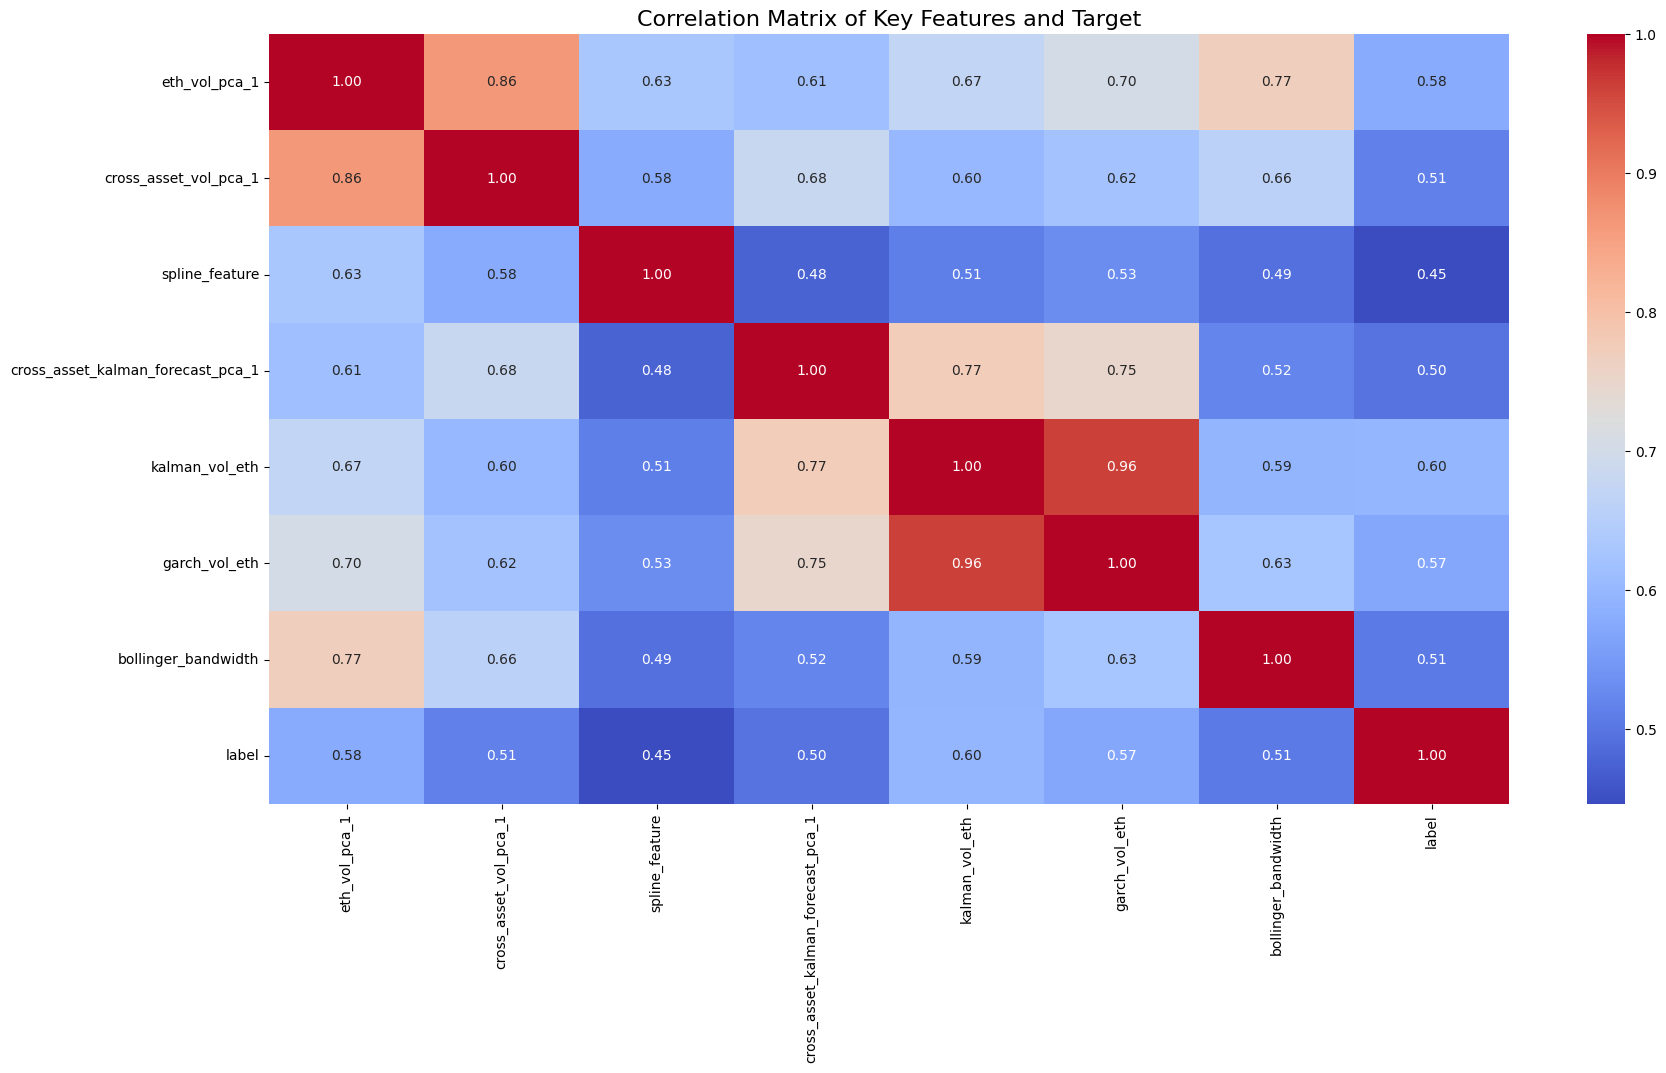

In [23]:
#Correlation Matrix between selected best features 
key_columns =  ['eth_vol_pca_1','cross_asset_vol_pca_1',
            'spline_feature','cross_asset_kalman_forecast_pca_1','kalman_vol_eth',
            'garch_vol_eth','bollinger_bandwidth','label']

correlation_matrix = train_set_final[key_columns].corr()

plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Key Features and Target', fontsize=16)
plt.show()

# Final Models 
## Xgboost


- **Objective**: Regression (`reg:squarederror`)  
- **Features Used**:  
  - `eth_vol_pca_1`  
  - `cross_asset_vol_pca_1`  
  - `spline_feature`  
  - `cross_asset_kalman_forecast_pca_1`  
  - `kalman_vol_eth`  
  - `garch_vol_eth`  
  - `bollinger_bandwidth`  

- **Hyperparameters**:  
  - Number of trees (`n_estimators`): **5000**  
  - Learning rate: **0.01**  
  - Maximum depth: **5**  
  - Subsample ratio: **0.8**  
  - Column sample ratio (`colsample_bytree`): **0.8**  
  - Early stopping: **100 rounds**  
  - Random state: **42**  

- **Performance Metrics**:  
  - Training R²: $0.43849557622874036$
  - Testing R²:  $0.3524020740357553$
  - RMSE (Test Set):  $0.00006631102$

- **Visualization**:  
  - Feature importance plot generated with `xgb.plot_importance`


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Training R² score: 0.43849557622874036
Testing R² score: 0.3524020740357553

RMSE of the final model on the test set: 6.631102789983134e-05


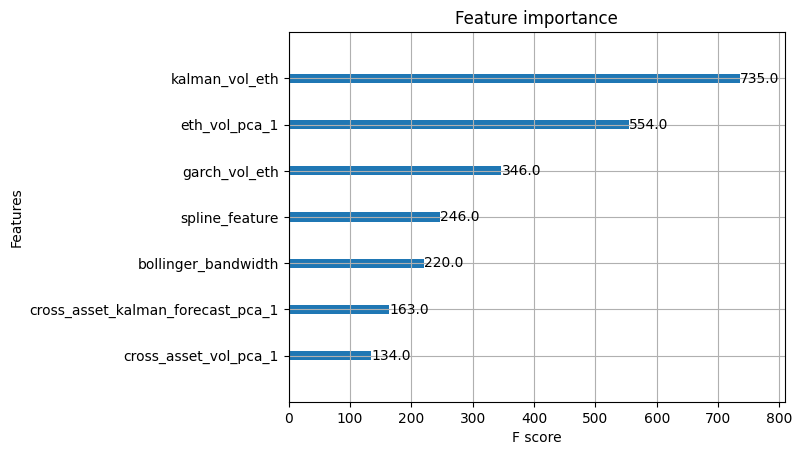

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
features = ['eth_vol_pca_1','cross_asset_vol_pca_1',
            'spline_feature','cross_asset_kalman_forecast_pca_1','kalman_vol_eth',
            'garch_vol_eth','bollinger_bandwidth']


X_train = train_set_final[features].fillna(0)
y_train = train_set_final['label'].fillna(0)

X_test = test_set_final[features].fillna(0) 
y_test = test_set_final['label'].fillna(0)

import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Initialize the XGBoost Regressor Model 
# We define the model with some common starting parameters.
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # Specifies the learning task and objective function.
    n_estimators=5000,            # The maximum number of trees to build.
    learning_rate=0.01,           # Step size shrinkage to prevent overfitting.
    max_depth=5,                  # Maximum depth of each tree.
    subsample=0.8,                # Fraction of samples to be used for fitting each tree.
    colsample_bytree=0.8,         # Fraction of features to be used for fitting each tree.
    n_jobs=-1,                    # Use all available CPU threads for speed.
    random_state=42               # For reproducibility.
)

# Train the model
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              early_stopping_rounds=100,
              verbose=False) 

#  Make Predictions on the Test Set 
predictions = xgb_model.predict(X_test)

# Evaluate the Model 
rmse = np.sqrt(mean_squared_error(y_test, predictions))
train_predictions = xgb_model.predict(X_train)
train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, predictions)

print("Training R² score:", train_r2)
print("Testing R² score:", test_r2)
print(f"\nRMSE of the final model on the test set: {rmse}")

xgb.plot_importance(xgb_model)
plt.show()

## Transformer Based Approach

**Goal:** Predict the target `label` from order book features and volatility indicators.

### **Data Preparation**
- **Features:** Includes price, volume, and volatility metrics (e.g., kalman forecast of ETH, garch forecast of ETH, cubic Spline feature, cross asset kalman feature, bid/ask levels up to 5). xgboost requires more processed feeatures, so we can't add raw order book data as features since it was adding noise to the model. That's why we needed Transformer based approach.
- **Target:** `label` (future value to predict).
- **Preprocessing:**
  - Missing values filled with `0`.
  - Clipping applied to features at the 0.1% and 99.9% quantiles to remove extreme outliers.
  - Features scaled using **RobustScaler**.
  - Target scaled using **RobustScaler**.
  - Time series converted into sequences with **60 timesteps** using `TimeseriesGenerator`.

### **Model Architecture**
A custom Transformer-based model with:
- **MultiHeadAttention** layers (`num_heads=4`, `head_size=256`).
- **LayerNormalization** after attention and feed-forward blocks.
- **Feed-Forward Network:** Dense → Dense with ReLU activation.
- **Dropout** for regularization.
- **GlobalAveragePooling1D** before final Dense layers.
- **Output Layer:** Dense(1) for regression.

### **Training**
- **Optimizer:** Adam (`learning_rate=1e-4`).
- **Loss:** Mean Squared Error (MSE).
- **Callbacks:** Early stopping with patience=10.
- **Epochs:** 15.
- **Batch Size:** 256.

### **Evaluation Metrics**
- **RMSE** (Root Mean Squared Error) on the test set.
- **R² Score** for both training and testing sets.
- Predictions inverse-transformed to original scale for evaluation.

**Outcome:** 


Test Set RMSE: $0.00006619$ 

Training R² Score: $0.4000$

Testing R² Score: $0.3550$

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, MultiHeadAttention, LayerNormalization, Dense, Dropout, GlobalAveragePooling1D
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.callbacks import EarlyStopping


features =['spline_feature','cross_asset_kalman_forecast_pca_1','kalman_vol_eth',
            'garch_vol_eth','bollinger_bandwidth','mid_price', 'bid_price1', 'bid_volume1', 'bid_price2', 'bid_volume2',
       'bid_price3', 'bid_volume3', 'bid_price4', 'bid_volume4', 'bid_price5',
       'bid_volume5', 'ask_price1', 'ask_volume1', 'ask_price2', 'ask_volume2',
       'ask_price3', 'ask_volume3', 'ask_price4', 'ask_volume4', 'ask_price5',
       'ask_volume5']
target = 'label'
X_train = train_set_final[features].fillna(0)
y_train = train_set_final[[target]].fillna(0)


X_test = test_set_final[features].fillna(0)
y_test = test_set_final[[target]].fillna(0)

#  Scale Data Robustly 
feature_scaler = RobustScaler()
target_scaler = RobustScaler()
clipping_limits = {}
for col in X_train.columns:
    # Calculate the upper and lower limits from the training data
    upper_limit = X_train[col].quantile(0.999)
    lower_limit = X_train[col].quantile(0.001)
    clipping_limits[col] = {'lower': lower_limit, 'upper': upper_limit}

#  Apply Clipping to BOTH Train and Test Sets 
lower_bounds = pd.Series({col: limits['lower'] for col, limits in clipping_limits.items()})
upper_bounds = pd.Series({col: limits['upper'] for col, limits in clipping_limits.items()})

X_train = X_train.clip(lower=lower_bounds, upper=upper_bounds, axis=1)
X_test = X_test.clip(lower=lower_bounds, upper=upper_bounds, axis=1)


X_train_scaled = feature_scaler.fit_transform(X_train)
y_train_scaled = target_scaler.fit_transform(y_train)
X_test_scaled = feature_scaler.transform(X_test)
y_test_scaled = target_scaler.transform(y_test)

# Prepare Data into Sequences 
n_timesteps = 60
n_features = X_train_scaled.shape[1]
train_generator = TimeseriesGenerator(X_train_scaled, y_train_scaled, length=n_timesteps, batch_size=256)
test_generator = TimeseriesGenerator(X_test_scaled, y_test_scaled, length=n_timesteps, batch_size=256)

# Build the Transformer Model Architecture 
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_blocks, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_blocks):
        attention_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x = LayerNormalization(epsilon=1e-6)(x + attention_output)
        ffn = Sequential([Dense(ff_dim, activation="relu"), Dense(input_shape[-1])])
        ffn_output = ffn(x)
        ffn_output = Dropout(dropout)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)
    x = GlobalAveragePooling1D(data_format="channels_last")(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

#  Instantiate and Compile the Model 
input_shape = (n_timesteps, n_features)
transformer_model = build_transformer_model(input_shape, head_size=256, num_heads=4, ff_dim=4, num_blocks=4, dropout=0.1)
transformer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="mean_squared_error")
transformer_model.summary()
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)
#  Train the Model 
print("\nTraining Transformer model for validation...")
transformer_model.fit(train_generator, epochs=15, validation_data=test_generator, verbose=1,callbacks=[early_stopping])
print("Transformer training complete.")

#  Make Predictions and Evaluate 
print("\nMaking predictions for evaluation...")
train_predictions_scaled = transformer_model.predict(train_generator)
test_predictions_scaled = transformer_model.predict(test_generator)

# Inverse transform predictions
train_predictions = target_scaler.inverse_transform(train_predictions_scaled)
test_predictions = target_scaler.inverse_transform(test_predictions_scaled)

# Align the true labels
y_train_actual = y_train.values[n_timesteps:]
y_test_actual = y_test.values[n_timesteps:]

# Calculate and print evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
training_r2 = r2_score(y_train_actual, train_predictions)
testing_r2 = r2_score(y_test_actual, test_predictions)

print("\n" + "="*30)
print("--- Transformer Model Evaluation ---")
print(f"Test Set RMSE: {rmse:.8f}")
print(f"Training R² Score: {training_r2:.4f}")
print(f"Testing R² Score: {testing_r2:.4f}")
print("="*30)

2025-08-16 07:37:27.907311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755329848.272810      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755329848.365214      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1755329868.228379      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755329868.229050      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 26)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 26)    │    109,594 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 26)    │          0 │ input_layer[0][0… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 60, 26)    │         52 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 60, 26)    │        238 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 60, 26)    │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 26)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 26)    │         52 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 26)    │    109,594 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 60, 26)    │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 26)    │         52 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 60, 26)    │        238 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 60, 26)    │          0 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 60, 26)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 26)    │         52 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 26)    │    109,594 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 60, 26)    │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 441,537 (1.68 MB)

 Trainable params: 441,537 (1.68 MB)

 Non-trainable params: 0 (0.00 B)


Training Transformer model for validation...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1755329885.587102     152 service.cc:148] XLA service 0x7cbce0002a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755329885.588947     152 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755329885.588966     152 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755329887.175476     152 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1973 ━━━━━━━━━━━━━━━━━━━━ 14:29:49 26s/step - loss: 1.0964

I0000 00:00:1755329896.534394     152 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1973/1973 ━━━━━━━━━━━━━━━━━━━━ 195s 86ms/step - loss: 0.5033 - val_loss: 1.3965
Epoch 2/15
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 163s 83ms/step - loss: 0.4193 - val_loss: 1.3723
Epoch 3/15
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 163s 83ms/step - loss: 0.4222 - val_loss: 1.2866
Epoch 4/15
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 163s 83ms/step - loss: 0.4378 - val_loss: 1.3488
Epoch 5/15
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 163s 83ms/step - loss: 0.4327 - val_loss: 1.3234
Epoch 6/15
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 163s 83ms/step - loss: 0.4138 - val_loss: 1.2629
Epoch 7/15
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 163s 83ms/step - loss: 0.4092 - val_loss: 1.2370
Epoch 8/15
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 163s 83ms/step - loss: 0.3763 - val_loss: 1.2575
Epoch 9/15
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 163s 83ms/step - loss: 0.4035 - val_loss: 1.2198
Epoch 10/15
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 163s 83ms/step - loss: 0.3872 - val_loss: 1.2547
Epoch 11/15
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 163s 83ms/step - loss: 0.4211 - val_loss: 1.2453
Epoch 12

## LSTM Model


**Goal:** Predict the target `label` using ETH order book features and volatility indicators.

### **Data Preparation**
- **Features:** Price, volume, and volatility metrics (Includes price, volume, and volatility metrics (e.g., kalman forecast of ETH, garch forecast of ETH, cubic Spline feature, cross asset kalman feature, bid/ask levels up to 5)., bid/ask levels up to 5, etc.).
- **Target:** `label`.
- **Preprocessing:**
  - Missing values filled with `0`.
  - Outlier clipping at the 0.1% and 99.9% quantiles (based on training set).
  - **RobustScaler** applied to features and target.
  - **TimeseriesGenerator** used to create sequences of **60 timesteps** for training.

### **Model Architecture**
A stable LSTM-based sequential model:
- **Layer 1:** LSTM(64, activation=`tanh`, return_sequences=True) + Dropout(0.2)
- **Layer 2:** LSTM(32, activation=`tanh`) + Dropout(0.2)
- **Output:** Dense(1) for regression.

### **Training Configuration**
- **Optimizer:** Adam (`learning_rate=1e-5`, `clipnorm=1.0`) to prevent gradient explosion.
- **Loss:** Mean Squared Error (MSE).
- **Callback:** Early stopping with patience=5, restoring best weights.
- **Epochs:** up to 50.
- **Batch Size:** 256.

### **Evaluation Metrics**
- **RMSE** (Root Mean Squared Error) on the test set.
- **R² Score** for both training and test predictions.
- Predictions inverse-scaled back to original units.

Test Set RMSE: 0.00006794

Training R² Score: 0.3968

Testing R² Score: 0.3203


In [42]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
# Define Features and Target 
features =['eth_vol_pca_1','cross_asset_vol_pca_1',
            'spline_feature','cross_asset_kalman_forecast_pca_1','kalman_vol_eth',
            'garch_vol_eth','bollinger_bandwidth','mid_price', 'bid_price1', 'bid_volume1', 'bid_price2', 'bid_volume2',
       'bid_price3', 'bid_volume3', 'bid_price4', 'bid_volume4', 'bid_price5',
       'bid_volume5', 'ask_price1', 'ask_volume1', 'ask_price2', 'ask_volume2',
       'ask_price3', 'ask_volume3', 'ask_price4', 'ask_volume4', 'ask_price5',
       'ask_volume5']
target = 'label'

X_train = train_set_final[features].fillna(0)
y_train = train_set_final[[target]].fillna(0)

X_test = test_set_final[features].fillna(0)
y_test = test_set_final[[target]].fillna(0)

# Scale Data Robustly 
feature_scaler = RobustScaler()
target_scaler = RobustScaler()
clipping_limits = {}
for col in X_train.columns:
    # Calculate the upper and lower limits from the training data
    upper_limit = X_train[col].quantile(0.999)
    lower_limit = X_train[col].quantile(0.001)
    clipping_limits[col] = {'lower': lower_limit, 'upper': upper_limit}

# Apply Clipping to BOTH Train and Test Sets 
lower_bounds = pd.Series({col: limits['lower'] for col, limits in clipping_limits.items()})
upper_bounds = pd.Series({col: limits['upper'] for col, limits in clipping_limits.items()})

X_train = X_train.clip(lower=lower_bounds, upper=upper_bounds, axis=1)
X_test = X_test.clip(lower=lower_bounds, upper=upper_bounds, axis=1)

X_train_scaled = feature_scaler.fit_transform(X_train)
y_train_scaled = target_scaler.fit_transform(y_train)
X_test_scaled = feature_scaler.transform(X_test)
y_test_scaled = target_scaler.transform(y_test)

# Prepare Sequences 
n_timesteps = 60
n_features = X_train.shape[1]
train_generator = TimeseriesGenerator(X_train_scaled, y_train_scaled, length=n_timesteps, batch_size=256)
test_generator = TimeseriesGenerator(X_test_scaled, y_test_scaled, length=n_timesteps, batch_size=256)

#  Build and Train a STABLE LSTM Model 
lstm_model = Sequential([
    Input(shape=(n_timesteps, n_features)),
    LSTM(64, activation='tanh', return_sequences=True), # Use tanh for stability
    Dropout(0.2),
    LSTM(32, activation='tanh'), # Use tanh for stability
    Dropout(0.2),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.0)
lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, # Stop after 5 epochs with no improvement
    restore_best_weights=True #  keeps the best version of the model
)
print("Training LSTM model for validation...")
lstm_model.fit(train_generator,
               epochs=50,
               validation_data=test_generator,
               verbose=1,
              callbacks=[early_stopping])
print("LSTM training complete.")

#  Make Predictions and Evaluate 
print("\nMaking predictions for evaluation...")
train_predictions_scaled = lstm_model.predict(train_generator)
test_predictions_scaled = lstm_model.predict(test_generator)

# Inverse transform predictions
train_predictions = target_scaler.inverse_transform(train_predictions_scaled)
test_predictions = target_scaler.inverse_transform(test_predictions_scaled)

# Align the true labels
y_train_actual = y_train.values[n_timesteps:]
y_test_actual = y_test.values[n_timesteps:]

# Calculate and print evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
training_r2 = r2_score(y_train_actual, train_predictions)
testing_r2 = r2_score(y_test_actual, test_predictions)

print("\n" + "="*30)
print("--- LSTM Model Evaluation ---")
print(f"Test Set RMSE: {rmse:.8f}")
print(f"Training R² Score: {training_r2:.4f}")
print(f"Testing R² Score: {testing_r2:.4f}")
print("="*30)

Training LSTM model for validation...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1973/1973 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - loss: 0.5210 - val_loss: 1.6762
Epoch 2/50
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.4050 - val_loss: 1.5390
Epoch 3/50
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.4072 - val_loss: 1.4816
Epoch 4/50
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.4263 - val_loss: 1.4417
Epoch 5/50
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.4429 - val_loss: 1.4166
Epoch 6/50
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.4161 - val_loss: 1.3843
Epoch 7/50
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.3966 - val_loss: 1.3715
Epoch 8/50
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.3944 - val_loss: 1.3616
Epoch 9/50
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.4204 - val_loss: 1.3474
Epoch 10/50
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.4284 - val_loss: 1.3388
Epoch 11/50
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.4113 - val_loss: 1.3341
Epoch 12/50
1973/19

Out of all the three models xgboost has shown comparatively better results and also for high frequency market data running transformer or LSTM may be time inefficient. So we choose xgboost as our final model for IV prediction with features as :
- `eth_vol_pca_1`  
- `cross_asset_vol_pca_1`  
- `spline_feature`  
- `cross_asset_kalman_forecast_pca_1`  
- `kalman_vol_eth`  
- `garch_vol_eth`  
- `bollinger_bandwidth`  (for eth only)

# Cross Validation

A simple **train/test split** is not enough to reliably evaluate a model:  
- A good score might occur just because the test set was unusually *easy*.  
- A bad score might occur just because the test set was unusually *hard*.  

This leaves us uncertain about how the model will perform on truly unseen future data.

**Time Series Cross-Validation (CV)** solves this by:  
- Splitting the data into several **chronological folds**.  
- Always training on **past data** and predicting the **immediate future**.  
- Averaging the results across all folds to get a **robust estimate** of performance.  

This script implements a **complete time-series cross-validation pipeline** to evaluate the performance of an **XGBoost model**.


1. **Setup**  
   - Initialize `TimeSeriesSplit` with **3 folds**.  
   - Prepare storage for metrics and prediction plots.  

2. **The Main Loop** (iterating over folds)  
   - For each fold, the script trains on past data and tests on future data.  

3. **In-Loop Feature Engineering** (to avoid leakage)  
   - Recalculate all features from scratch for each fold:  
     - **Volatility features** from GARCH and Kalman Filter models.  
     - **Time-based features** like a cubic spline.  
     - **Dimensionality reduction** using hierarchical PCA on volatility metrics.  

4. **Model Training & Evaluation**  
   - Train a fresh **XGBoost Regressor** on the training set of each fold.  
   - Generate predictions on the validation set.  

5. **Storing Results**  
   - Collect metrics: **RMSE**, **Train R²**, **Test R²**.  
   - Plot **Predictions vs Actuals** for each fold.  

6. **Final Summary**  
   - After all folds are complete:  
     - Display plots.  
     - Print a summary table with fold-wise metrics.  
     - Compute overall **average and standard deviation** of performance.  

---

 **End result:** A rigorous, leakage-free validation process that gives confidence in the model’s generalization ability on future time periods.



In [65]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from tqdm import tqdm

full_labeled_data = ETH_train_filled.copy()

cross_assets = ['BTC', 'DOGE', 'DOT', 'LINK', 'SHIB', 'SOL']

print("Combining all asset data into a single DataFrame...")
#  Loop through each cross-asset, rename its columns, and merge 
for asset in cross_assets:
    # Get the DataFrame for the current asset
    asset_df = globals()[f"{asset}_train_filled"]
    
    #Create a dictionary to rename the columns 
    # We add the asset name as a prefix (e.g., 'mid_price' -> 'btc_mid_price')
    # We exclude 'label' from renaming as it only exists in the ETH df.
    rename_dict = {
        col: f"{asset.lower()}_{col}" 
        for col in asset_df.columns if col != 'label'
    }
    
    # Select all columns except 'label', rename them, and prepare for merging
    features_to_merge = asset_df.rename(columns=rename_dict)
    
    # Merge the renamed features into  main DataFrame using the timestamp index
    full_labeled_data = full_labeled_data.merge(
        features_to_merge, 
        left_index=True, 
        right_index=True, 
        how='left'
    )
    
    print(f"Merged features from {asset}")

# Final cleanup 
# The merges might create some NaNs if the time ranges aren't perfectly aligned.
full_labeled_data.ffill(inplace=True)
full_labeled_data.bfill(inplace=True)

Combining all asset data into a single DataFrame...
-> Merged features from BTC
-> Merged features from DOGE
-> Merged features from DOT
-> Merged features from LINK
-> Merged features from SHIB
-> Merged features from SOL


Starting 3-Fold Time Series Cross-Validation with in-loop feature generation...


0it [00:00, ?it/s]

Adding GARCH & Kalman features for btc...
GARCH & Kalman features added.
Adding GARCH & Kalman features for sol...
GARCH & Kalman features added.
Adding GARCH & Kalman features for doge...
GARCH & Kalman features added.
Adding GARCH & Kalman features for dot...
GARCH & Kalman features added.
Adding GARCH & Kalman features for link...
GARCH & Kalman features added.
Adding GARCH & Kalman features for shib...
GARCH & Kalman features added.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.301e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Spline model fitted on the training data.
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 92.34%
Creating 1 PCA features from 6 columns...
Explained variance by 1 components: 100.00%
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 89.20%
BTC
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 86.37%
DOGE
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 80.30%
DOT
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 88.56%
LINK
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 89.68%
SHIB
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 92.62%
SOL
Creating 1 PCA features from 6 columns...
Explained variance by 1 components: 75.49%


1it [16:36, 996.38s/it]

Adding GARCH & Kalman features for btc...
GARCH & Kalman features added.
Adding GARCH & Kalman features for sol...
GARCH & Kalman features added.
Adding GARCH & Kalman features for doge...
GARCH & Kalman features added.
Adding GARCH & Kalman features for dot...
GARCH & Kalman features added.
Adding GARCH & Kalman features for link...
GARCH & Kalman features added.
Adding GARCH & Kalman features for shib...
GARCH & Kalman features added.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.367e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Spline model fitted on the training data.
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 91.63%
Creating 1 PCA features from 6 columns...
Explained variance by 1 components: 100.00%
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 90.43%
BTC
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 87.12%
DOGE
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 80.00%
DOT
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 86.18%
LINK
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 88.94%
SHIB
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 91.61%
SOL
Creating 1 PCA features from 6 columns...
Explained variance by 1 components: 70.80%


2it [36:55, 1127.37s/it]

Adding GARCH & Kalman features for btc...
GARCH & Kalman features added.
Adding GARCH & Kalman features for sol...
GARCH & Kalman features added.
Adding GARCH & Kalman features for doge...
GARCH & Kalman features added.
Adding GARCH & Kalman features for dot...
GARCH & Kalman features added.
Adding GARCH & Kalman features for link...
GARCH & Kalman features added.
Adding GARCH & Kalman features for shib...
GARCH & Kalman features added.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.81e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Spline model fitted on the training data.
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 89.99%
Creating 1 PCA features from 6 columns...
Explained variance by 1 components: 100.00%
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 89.91%
BTC
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 86.91%
DOGE
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 81.10%
DOT
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 85.67%
LINK
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 88.85%
SHIB
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 89.97%
SOL
Creating 1 PCA features from 6 columns...
Explained variance by 1 components: 70.82%


3it [1:00:53, 1217.91s/it]


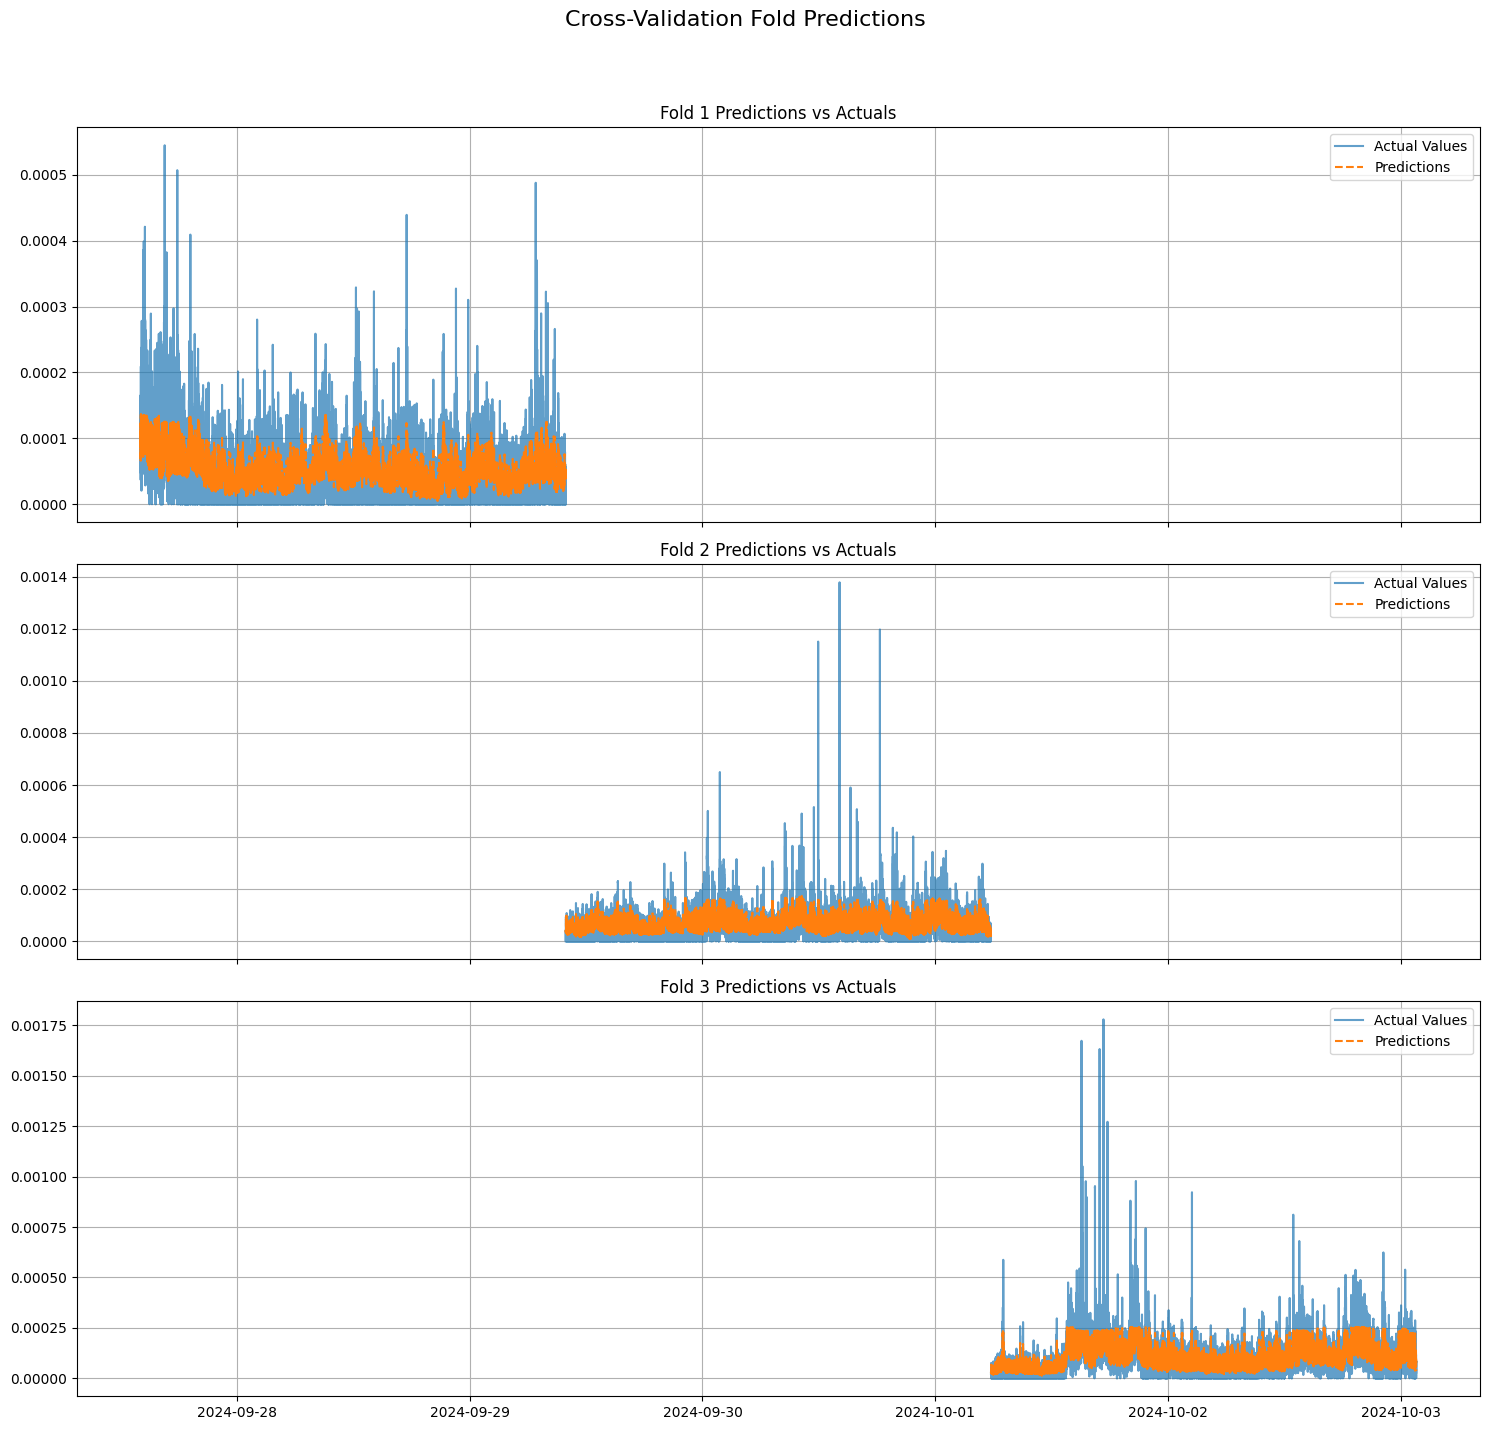


--- Cross-Validation Metrics Summary ---


,Fold,Train R2,Test R2,Test RMSE
0,1,0.483000,0.308469,0.000035
1,2,0.454735,0.282330,0.000042
2,3,0.424872,0.470184,0.000059



--- Average Performance ---


Train R2     0.454202
Test R2      0.353661
Test RMSE    0.000046
dtype: float64

In [84]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lists to store metrics from each fold
results = []

# Create a figure to hold the plots from each fold
fig, axes = plt.subplots(n_splits, 1, figsize=(15, n_splits * 5), sharex=True)
fig.suptitle('Cross-Validation Fold Predictions', fontsize=16)

print(f"Starting {n_splits}-Fold Time Series Cross-Validation with in-loop feature generation...")

# Loop Through Each Fold 
for fold, (train_index, val_index) in enumerate(tqdm(tscv.split(full_labeled_data))):
    # Split the base data for the current fold
    train_fold = full_labeled_data.iloc[train_index].copy()
    val_fold = full_labeled_data.iloc[val_index].copy()
    train_fold = add_bollinger_bandwidth(train_fold)
    val_fold = add_bollinger_bandwidth(val_fold)
    # Generate All Advanced Features INSIDE the loop 
    # a) GARCH/Kalman for all assets
    for asset in ['btc', 'sol', 'doge', 'dot', 'link', 'shib']:
        train_fold, val_fold = add_advanced_vol_features(train_fold, val_fold, asset)

    train_returns = 100 * np.log(train_fold['mid_price']).diff().dropna()
    garch_model = arch_model(train_returns, p=1, q=1, vol='Garch')
    garch_fit = garch_model.fit(disp='off')
    
    # Add in-sample feature to the training set
    train_fold['garch_vol_eth'] = np.sqrt(garch_fit.conditional_volatility) / 100
    
    # Generate out-of-sample forecast for the test set
    forecasts = garch_fit.forecast(horizon=len(test_df), reindex=False)
    predicted_variance = forecasts.variance.iloc[0].values
    aligned_forecasts = pd.Series(predicted_variance, index=test_df.index)
    val_fold['garch_vol_eth'] = np.sqrt(aligned_forecasts)

    # Kalman Filter Feature 
    train_obs = np.log(train_fold['mid_price']).diff().dropna()**2
    test_obs = np.log(val_fold['mid_price']).diff().dropna()**2
    
    # Initialize and fit on training data
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1, transition_covariance=0.01, 
                      observation_covariance=1, transition_matrices=[1], 
                      observation_matrices=[1], initial_state_covariance=1)
    state_means_train, state_covs_train = kf.filter(train_obs.values)
    
    #  Add in-sample feature to the training set
    train_fold['kalman_vol_eth'] = pd.Series(np.sqrt(np.maximum(0, state_means_train.flatten())), index=train_obs.index)

    #  Generate out-of-sample forecast for the test set (online)
    last_state_mean = state_means_train[-1]
    last_state_cov = state_covs_train[-1]
    state_means_test = []
    for obs in test_obs.values:
        last_state_mean, last_state_cov = kf.filter_update(
            filtered_state_mean=last_state_mean,
            filtered_state_covariance=last_state_cov,
            observation=obs
        )
        state_means_test.append(last_state_mean[0])
    
    val_fold['kalman_vol_eth'] = pd.Series(np.sqrt(np.maximum(0, state_means_test)), index=test_obs.index)

    #b) Cubic Spline
    train_fold['time_numeric'] = (train_fold.index - train_fold.index.min()).total_seconds()
    val_fold['time_numeric'] = (val_fold.index - val_fold.index.min()).total_seconds()
    
    formula = "label ~ bs(time_numeric, df=30, degree=3, include_intercept=False)"
    y_train_spline, X_train_spline = dmatrices(formula, data=train_fold, return_type='dataframe')
    spline_model = sm.GLM(y_train_spline, X_train_spline)
    spline_results = spline_model.fit()
    print("Spline model fitted on the training data.")
    
    # Add the feature to the training set
    train_fold['spline_feature'] = spline_results.predict(X_train_spline)
    
    X_test_spline = dmatrix("bs(time_numeric, df=30, degree=3, include_intercept=False)",
                            data=val_fold,
                            return_type='dataframe')
    
    # Use the fitted spline_results to predict on the new X_test_spline
    val_fold['spline_feature'] = spline_results.predict(X_test_spline)
    # b) PCA features (example for ETH volatility)
    eth_vol_features = [
    'rolling_vol_ETH', 
    'parkinson_vol_eth', 
    'garman_klass_vol_eth', 
    'yang_zhang_vol_eth'
    ]
    # garch_forecast = ['garch_vol_doge','garch_vol_dot','garch_vol_link','garch_vol_shib','garch_vol_sol']
    kalman_forecast = ['kalman_vol_btc','kalman_vol_doge','kalman_vol_dot','kalman_vol_link','kalman_vol_shib','kalman_vol_sol']
    # price_features = ['mid_price','btc_mid_price','doge_mid_price','dot_mid_price','link_mid_price','shib_mid_price','sol_mid_price',]
    
    vol_features = ['btc_vol_pca_1',
           'doge_vol_pca_1', 'dot_vol_pca_1', 'link_vol_pca_1', 'shib_vol_pca_1',
           'sol_vol_pca_1']
    train_fold, val_fold = create_pca_features(
        train_fold, val_fold, columns_to_combine=eth_vol_features,n_components=1, prefix='eth_vol_pca'
    )
    
    train_fold, val_fold = create_pca_features(
        train_fold, 
        val_fold, 
        columns_to_combine=kalman_forecast,
        n_components=1, # Start with 2 components
        prefix='cross_asset_kalman_forecast_pca'
    )
    for asset in cross_assets:
        asset_low = asset.lower()
        vol_features = [f'{asset_low}_parkinson_vol_{asset_low}',
           f'{asset_low}_garman_klass_vol_{asset_low}', f'{asset_low}_yang_zhang_vol_{asset_low}',f'{asset_low}_rolling_vol_{asset}']
        train_fold, val_fold = create_pca_features(
        train_fold, 
        val_fold, 
        columns_to_combine=vol_features,
        n_components=1, # Start with 2 components
        prefix=f'{asset_low}_vol_pca'
                        )
        print(asset)
    vol_features = ['btc_vol_pca_1',
           'doge_vol_pca_1', 'dot_vol_pca_1', 'link_vol_pca_1', 'shib_vol_pca_1',
           'sol_vol_pca_1']
    train_fold, val_fold = create_pca_features(
        train_fold, 
        val_fold, 
        columns_to_combine=vol_features,
        n_components=1,
        prefix='cross_asset_vol_pca'
    )

    #  Prepare final features for this fold ---
    final_features = ['eth_vol_pca_1','cross_asset_vol_pca_1',
            'spline_feature','cross_asset_kalman_forecast_pca_1','kalman_vol_eth',
            'garch_vol_eth','bollinger_bandwidth']

    target = 'label'

    X_train_fold = train_fold[final_features].fillna(0)
    y_train_fold = train_fold[target].fillna(0)
    X_val_fold = val_fold[final_features].fillna(0)
    y_val_fold = val_fold[target].fillna(0)
    
    # Train the XGBoost Model for This Fold 
    xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # Specifies the learning task and objective function.
    n_estimators=5000,            # The maximum number of trees to build.
    learning_rate=0.01,           # Step size shrinkage to prevent overfitting.
    max_depth=5,                  # Maximum depth of each tree.
    subsample=0.8,                # Fraction of samples to be used for fitting each tree.
    colsample_bytree=0.8,         # Fraction of features to be used for fitting each tree.
    n_jobs=-1,                    # Use all available CPU threads for speed.
    random_state=42               # For reproducibility.
        )
    
    xgb_model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_val_fold, y_val_fold)],
                  verbose=False)
    
    #  Predict and Store Metrics 
    train_preds = xgb_model.predict(X_train_fold)
    val_preds = xgb_model.predict(X_val_fold)
    
    results.append({
        'Fold': fold + 1,
        'Train R2': r2_score(y_train_fold, train_preds),
        'Test R2': r2_score(y_val_fold, val_preds),
        'Test RMSE': np.sqrt(mean_squared_error(y_val_fold, val_preds))
    })
    
    #  Plot Predictions for This Fold 
    ax = axes[fold]
    ax.plot(y_val_fold.index, y_val_fold.values, label='Actual Values', alpha=0.7)
    ax.plot(y_val_fold.index, val_preds, label='Predictions', linestyle='--')
    ax.set_title(f'Fold {fold+1} Predictions vs Actuals')
    ax.legend()
    ax.grid(True)

# Summarize and Display Results 
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Convert results to a DataFrame for a clean summary
results_df = pd.DataFrame(results)
print("\n" + "="*40)
print("--- Cross-Validation Metrics Summary ---")
display(results_df)

print("\n--- Average Performance ---")
display(results_df.drop(columns='Fold').mean())
print("="*40)

# Implementing on Full Training and Testing Set

In [29]:
BTC_train_filled.columns

Index(['mid_price', 'bid_price1', 'bid_volume1', 'bid_price2', 'bid_volume2',
       'bid_price3', 'bid_volume3', 'bid_price4', 'bid_volume4', 'bid_price5',
       'bid_volume5', 'ask_price1', 'ask_volume1', 'ask_price2', 'ask_volume2',
       'ask_price3', 'ask_volume3', 'ask_price4', 'ask_volume4', 'ask_price5',
       'ask_volume5', 'log_return', 'rolling_vol_BTC', 'wap1_BTC', 'wap2_BTC',
       'wap3_BTC', 'wap4_BTC', 'wap5_BTC', 'obi_BTC', 'parkinson_vol_btc',
       'garman_klass_vol_btc', 'yang_zhang_vol_btc', 'bollinger_bandwidth',
       'garch_vol_btc', 'kalman_vol_btc'],
      dtype='object')

In [28]:
assets = ['ETH','BTC','DOGE','DOT','SHIB','SOL']
for asset in assets : 
    df_train = globals()[f"{asset}_train_filled"]
    df_test =  globals()[f"{asset}_test_filled"]
    df_train_ad, df_test_ad = add_advanced_vol_features(df_train, df_test, asset.lower())
    globals()[f"{asset}_train_set"] = df_train_ad
    globals()[f"{asset}_test_set"] = df_test_ad
    print(asset)

Adding GARCH & Kalman features for eth...
GARCH & Kalman features added.
ETH
Adding GARCH & Kalman features for btc...


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.457e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


GARCH & Kalman features added.
BTC
Adding GARCH & Kalman features for doge...


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002443. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


GARCH & Kalman features added.
DOGE
Adding GARCH & Kalman features for dot...


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001523. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


GARCH & Kalman features added.
DOT
Adding GARCH & Kalman features for shib...


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005235. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


GARCH & Kalman features added.
SHIB
Adding GARCH & Kalman features for sol...


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001264. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


GARCH & Kalman features added.
SOL


In [34]:
test = pd.read_csv("/kaggle/input/gq-dataset/test/ETH.csv")
test['timestamp'] = pd.to_datetime(test['timestamp'], format='%d-%m-%Y %H:%M')
test['seconds_to_add'] = test.groupby('timestamp').cumcount()
test['new_timestamp'] = test['timestamp'] + pd.to_timedelta(test['seconds_to_add'], unit='s')
test.drop(columns = ['timestamp','seconds_to_add'],inplace =True)
test.rename(columns = {'new_timestamp':'timestamp'},inplace=True)

test = test.set_index('timestamp')
original_submission_index = test.index


#Merging all the cross-asset train sets into ETH_train set

train_set_final = ETH_train_set.copy()
test_set_final = ETH_test_set.copy()

cross_assets = ['BTC', 'DOGE', 'DOT', 'LINK', 'SHIB', 'SOL']

print("Starting to merge cross-asset features...")
for asset in cross_assets:
    asset_lower = asset.lower()
    
    # Get the source train and test DataFrames
    train_df_source = globals()[f"{asset}_train_set"]
    test_df_source = globals()[f"{asset}_test_set"]
    
    # Define the columns to select and how to rename them
    features_to_rename = {
        'mid_price': f'{asset_lower}_mid_price',
        f'rolling_vol_{asset}': f'{asset_lower}_rolling_vol',
        f'garch_vol_{asset_lower}': f'{asset_lower}_garch_vol',
        f'kalman_vol_{asset_lower}': f'{asset_lower}_kalman_vol',
        f'parkinson_vol_{asset_lower}': f'{asset_lower}_parkinson_vol',
        f'garman_klass_vol_{asset_lower}': f'{asset_lower}_garman_klass_vol',
        f'yang_zhang_vol_{asset_lower}': f'{asset_lower}_yang_zhang_vol'
    }
    
    # Select and rename features
    train_features = train_df_source[list(features_to_rename.keys())].rename(columns=features_to_rename)
    test_features = test_df_source[list(features_to_rename.keys())].rename(columns=features_to_rename)
    
    
    train_set_final = train_set_final.merge(train_features, left_index=True, right_index=True, how='left')
    test_set_final = test_set_final.merge(test_features, left_index=True, right_index=True, how='left')
    
    print(f"-> Merged features from {asset}")

# Final cleanup of NaNs created during merges 
train_set_final.ffill(inplace=True)
train_set_final.bfill(inplace=True)
test_set_final.ffill(inplace=True)
test_set_final.bfill(inplace=True)

print("\n All cross-asset features have been merged.")

#  Verify the final result 
print("\n--- Final Training Set Preview ---")
display(train_set_final[['label', 'btc_mid_price', 'sol_rolling_vol', 'doge_kalman_vol']].head())

Starting to merge cross-asset features...
-> Merged features from BTC
-> Merged features from DOGE
-> Merged features from DOT
-> Merged features from LINK
-> Merged features from SHIB
-> Merged features from SOL

 All cross-asset features have been merged.

--- Final Training Set Preview ---


,label,btc_mid_price,sol_rolling_vol,doge_kalman_vol
2024-09-25 18:13:28,0.000060,63225.45,0.000107,0.000056
2024-09-25 18:13:29,0.000057,63225.45,0.000107,0.000054
2024-09-25 18:13:30,0.000080,63225.45,0.000107,0.000051
2024-09-25 18:13:31,0.000087,63225.45,0.000107,0.000056
2024-09-25 18:13:32,0.000090,63225.45,0.000107,0.000053


In [36]:

#Features which have high correlation 
eth_vol_features = [
    'rolling_vol_ETH', 
    'parkinson_vol_eth', 
    'garman_klass_vol_eth', 
    'yang_zhang_vol_eth'
]
# garch_forecast = ['doge_garch_vol','dot_garch_vol','link_garch_vol','shib_garch_vol','sol_garch_vol']
kalman_forecast = ['btc_kalman_vol','doge_kalman_vol','dot_kalman_vol','link_kalman_vol','shib_kalman_vol','sol_kalman_vol']
price_features = ['mid_price','btc_mid_price','doge_mid_price','dot_mid_price','link_mid_price','shib_mid_price','sol_mid_price',]

vol_features = ['btc_vol_pca_1',
       'doge_vol_pca_1', 'dot_vol_pca_1', 'link_vol_pca_1', 'shib_vol_pca_1',
       'sol_vol_pca_1']
train_set_final, test_set_final = create_pca_features(
    train_set_final, 
    test_set_final, 
    columns_to_combine=eth_vol_features,
    n_components=1, 
    prefix='eth_vol_pca'
)
train_set_final, test_set_final = create_pca_features(
    train_set_final, 
    test_set_final, 
    columns_to_combine=kalman_forecast,
    n_components=1, 
    prefix='cross_asset_kalman_forecast_pca'
)
for asset in cross_assets:
    asset_low = asset.lower()
    vol_features = [f'{asset_low}_parkinson_vol',
       f'{asset_low}_garman_klass_vol', f'{asset_low}_yang_zhang_vol',f'{asset_low}_rolling_vol']
    train_set_final, test_set_final = create_pca_features(
    train_set_final, 
    test_set_final, 
    columns_to_combine=vol_features,
    n_components=1,
    prefix=f'{asset_low}_vol_pca'
                    )
    print(asset)
vol_features = ['btc_vol_pca_1',
       'doge_vol_pca_1', 'dot_vol_pca_1', 'link_vol_pca_1', 'shib_vol_pca_1',
       'sol_vol_pca_1']
train_set_final, test_set_final = create_pca_features(
    train_set_final, 
    test_set_final, 
    columns_to_combine=vol_features,
    n_components=1, 
    prefix='cross_asset_vol_pca'
)

Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 77.52%
Creating 1 PCA features from 6 columns...
Explained variance by 1 components: 67.85%
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 92.06%
BTC
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 88.93%
DOGE
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 87.59%
DOT
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 93.79%
LINK
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 88.99%
SHIB
Creating 1 PCA features from 4 columns...
Explained variance by 1 components: 91.82%
SOL
Creating 1 PCA features from 6 columns...
Explained variance by 1 components: 74.48%


In [37]:
features =  ['eth_vol_pca_1','cross_asset_vol_pca_1',
            'spline_feature','cross_asset_kalman_forecast_pca_1','kalman_vol_eth',
            'garch_vol_eth','bollinger_bandwidth']

X_train_full = train_set_final[features].fillna(0)
y_train_full = train_set_final['label'].fillna(0)

# The test set for prediction
X_test_final = test_set_final[features].fillna(0)

#  Initialize and Train the Final XGBoost Model 
final_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=5000, # A reasonable number of trees
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)

print("Training final XGBoost model on all available training data...")
final_xgb_model.fit(X_train_full, y_train_full, verbose=False)
print(" Final model training complete.")

# Make Predictions on the Test Set 
all_predictions = final_xgb_model.predict(X_test_final)
predictions_df = pd.DataFrame(data=all_predictions, index=X_test_final.index, columns=['labels'])
# Filter Predictions to Match Original Timestamps 
predictions_reindexed = predictions_df.reindex(original_submission_index)
predictions_filled = predictions_reindexed.fillna(method='bfill').fillna(method='ffill')

submission_df = pd.DataFrame({
    'timestamp': np.arange(len(predictions_filled)) + 1,
    'labels': predictions_filled['labels'].values
})

print("\n--- Final Submission File Preview ---")
display(submission_df.head())


Training final XGBoost model on all available training data...
 Final model training complete.

--- Final Submission File Preview ---


/tmp/ipykernel_36/2096526129.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  predictions_filled = predictions_reindexed.fillna(method='bfill').fillna(method='ffill')


,timestamp,labels
0,1,0.000051
1,2,0.000051
2,3,0.000062
3,4,0.000065
4,5,0.000073


In [38]:
submission_df.to_csv('submission.csv', index=False)

# Trading Strategy

## The IV-OFI Volatility Breakout Strategy

We will use predicted 10s ahead IV as volatility breakout signal in market and `Order Flow Imbalance` as the entry or exit direction indicator.

1.  **Volatility**: A sudden spike in our predicted IV tells us the market is about to experience a significant repricing event. We're not reacting to volatility that has already happened; we're positioning for volatility we expect is about to happen. To quantify a "spike," we'll use a rolling Z-score of our IV predictions. A high Z-score signals an unusual event.
2.  **Order Flow Imbalance**: is the net change in aggressive buying and selling pressure at the top of the order book. The  formula is:$
\text{OFI}_t = \Delta V^{\text{bid}}_t - \Delta V^{\text{ask}}_t
$ where
$$
\Delta V^{\text{bid}}_t =
\begin{cases}
V^{\text{bid}}_t & \text{if } P^{\text{bid}}_t > P^{\text{bid}}_{t-1} \\
V^{\text{bid}}_t - V^{\text{bid}}_{t-1} & \text{if } P^{\text{bid}}_t = P^{\text{bid}}_{t-1} \\
- V^{\text{bid}}_{t-1} & \text{if } P^{\text{bid}}_t < P^{\text{bid}}_{t-1}
\end{cases}
$$

- $P^{\text{bid}}_t$ is the best bid price at time $t$.
- $V^{\text{bid}}_t$ is the volume at the best bid price at time $t$.
$$
\Delta V^{\text{ask}}_t =
\begin{cases}
V^{\text{ask}}_t & \text{if } P^{\text{ask}}_t < P^{\text{ask}}_{t-1} \\
V^{\text{ask}}_t - V^{\text{ask}}_{t-1} & \text{if } P^{\text{ask}}_t = P^{\text{ask}}_{t-1} \\
- V^{\text{ask}}_{t-1} & \text{if } P^{\text{ask}}_t > P^{\text{ask}}_{t-1}
\end{cases}
$$

- $P^{\text{ask}}_t$ is the best ask price at time $t$.
- $V^{\text{ask}}_t$ is the volume at the best ask price at time $t$.

3. **Interpretation**: Although IV will predict a volatility breakout regime, but it alone can't predict the direction of the market. So for the direction we need OFI, a positive OFI indicates net buying pressure. More aggressive buyers are entering the market (placing higher bids or consuming ask-side liquidity) than aggressive sellers. This suggests an upward pressure on price. Whereas a negative OFI indicates net selling pressure. More aggressive sellers are active (placing lower asks or consuming bid-side liquidity) than aggressive buyers. This suggests a downward pressure on price. We will use `OFI_SMA_5s` for smoother signals and `zscore_IV_1hr` i.e. rolling 1 hour zscore of IV.

## Entry and Exit Logic 
### Entry Logic : 

When `zscore_IV_1hr` $> x $ **AND** 

    *  Long Entry if `OFI_SMA_5s` is strongly positive, confirming immediate buying pressure.
    *  Short Entry if `OFI_SMA_5s` is strongly negative, confirming immediate selling pressure.

Here $x$ can be any predefined constant like $2,3,...$ which can vary from market to market.

### Exit Logic:
There can be multiple exit strategies :
1. If `zscore_IV_1hr` $<x $
2. If `OFI_SMA_5s` changes its sign or becomes strongly negative/positive.
3. A hard stop at a 0.5% loss to manage risk. Also exit any trade that hasn't hit a profit or stop loss after 5 minutes. Breakout trades should work quickly or not at all.